# Projet 1 (semaines 1 à 4) : Reversi 

## Semaine 3 : Une histoire de bandits


In [1]:
#LEBLEU Alexandre 21310941
#LOTH David 21305884

%load_ext autoreload
%autoreload 2
from reversi import Reversi, play_game
import tme3
import numpy as np
import matplotlib.pyplot as plt


Le dilemme dit de *l'exploration vs exploitation* est un problème fondamental que l'on retrouve dans plusieurs domaines de l'intelligence artificielle, en particulier en Machine Learning : parmi un certain nombre de choix possibles, vaut-il mieux *exploiter* la connaissance acquise et choisir l'action  estimée la plus rentable ou vaut-il mieux continuer à *explorer* d'autres actions afin d'acquérir plus d'informations ? 

L'exploitation consiste à faire la meilleure décision à partir de toute l'information collectée, l'exploration consiste à obtenir plus d'information. Il est parfois préférable, souvent au début d'un processus, de faire des sacrifices et de ne pas choisir l'option a priori la plus rentable afin d'améliorer le gain à long terme. Mais la question reste de savoir quand arrêter d'explorer, i.e. quand estime-t-on avoir recueilli assez d'informations et que l'exploration n'apportera pas de connaissances supplémentaires.

Un exemple d'application est l'intelligence artificielle pour les jeux de stratégie. C'est d'ailleurs un concept au coeur des premières IA qui ont révolutionnées l'approche pour le  jeu de GO, que l'on retrouve également sous une forme plus complexe dans AlphaGO. La question qui se pose dans ce contexte est de savoir s'il vaut mieux jouer le coup identifié comme le meilleur ou faut-il tenter un coup qui a été peu joué, au risque bien sûr de perdre la partie.


## III.1 Préambule : formalisation du problème des bandits

Afin de formaliser le problème de l'exploration/exploitation, on prend souvent l'exemple des [bandits manchots](https://fr.wikipedia.org/wiki/Machine_%C3%A0_sous) (ou machines à sous), ce jeu de hasard qu'on retrouve dans tout casino qui se respecte : pour une mise, on a le droit d'actionner un levier qui fait tourner des rouleaux, et en fonction de la combinaison obtenue sur les rouleaux, une récompense est attribué au joueur. 

Supposons une machine à sous à  $N$ leviers dénotés par l'ensemble $\{1,2,\ldots,N\}$. Chacun de ses leviers est une action possible parmi lesquelles le joueur doit choisir à chaque pas de temps : nous noterons  $a_t \in \{1,\ldots,N\}$ l'action choisie à un temps $t$.  Pour simplifier la modélisation, nous supposerons dans la suite que la récompense associée à chaque levier $i$ suit une distribution de Bernoulli de paramètre $\mu^i$ : avec une probabilité $\mu^i$ le joueur obtient une récompense de 1, avec une probabilité $1-\mu^i$ le joueur obtient une récompense de 0. 

Cette récompense obtenue au temps $t$ lorsque le joueur joue sera notée $r_t$. En notant $a_t$ l'action jouée au temps $t$, $r_t$ est donc une variable aléatoire qui suit une loi de Bernoulli de paramètre $\mu^{a_t}$. On suppose de plus que le rendement de chaque levier est stationnaire dans le temps, c'est-à-dire que les $\{\mu^i\}$ sont constants tout au long de la partie.

Pour le joueur, le gain au bout de $T$ parties est la somme des récompenses qu'il a obtenu pendant les $T$ première parties, soit $G_T = \sum_{t=0}^T r_t$ (n.b. la récompense étant aléatoire, le gain $G_T$ est une variable aléatoire, tout comme $r_t$). Son but est bien sûr de maximiser ce gain. Pour cela, il faut que le joueur identifie le levier au rendement le plus élevé : $i^* = argmax_{i \in \{1,\ldots,N\}} \mu^i$ et le rendement associé : $\mu^* = \mu^{i^*}=max_{i\in \{1,\ldots,n\}}\mu^i$.
Si le joueur joue un autre levier que $i^*$, il aura en moyenne un gain total inférieur au gain maximal qu'il peut espérer. Ce gain maximal à un  temps $T$ s'écrit $G_T^*=\sum_{i=1}^T r_t^*$, avec $r_t^*$ la récompense aléatoire  tirée de la distribution de Bernoulli de paramètre $\mu^*$.
On appelle regret au temps $T$ la différence entre le gain maximal espéré et le gain du joueur : $L_T= G^* - \sum_{t=1}^T r_t=\sum_{t=1}^T (r_t^*-r_t)$. L'objectif est donc  de minimiser ce regret.

Nous noterons par la suite :
* $N_T(a)$ le nombre de fois où l'action (le levier) $a$ a été choisi jusqu'au temps $T$.
* $\hat{\mu}_T^a=\frac{1}{N_T(a)}\sum_{t=1}^Tr_t\mathbf{1}_{a_t=a}$ la récompense moyenne estimée pour l'action/levier $a$ à partir des essais du joueur.


Codez une classe **Bandit** munie : 
* d'un constructeur qui prend en paramètre un entier **n** (le nombre de machines à sous) et initialise une liste **bandits** composée de **n** réels entre 0 et 1, correspondant au rendement des machines (la probabilité d'obtenir 1 en récompense);
* d'une méthode **play(i)** qui permet de simuler un coup joué sur la $i$-ème machine : elle renvoie 1 si le tirage est réussi, 0 sinon.

Vous aurez besoin dans toute la suite d'utiliser le module [**numpy.random**](https://numpy.org/doc/stable/reference/random/index.html)

In [2]:
bandit = tme3.Bandit(10)
print(bandit.bandits)
tirages = [bandit.play(1) for i in range(100)]
print(tirages)

[0.78022999 0.75417512 0.90783879 0.5749314  0.60197918 0.49592269
 0.61560597 0.82481058 0.33411917 0.00280568]
[1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1]


## III.2 Algorithme aléatoire 

Codez une classe **AgentBanditRandom** munie :
* d'un constructeur prenant en paramètre un entier **n** le nombre de machines à sous, qui initialise deux tableaux **times** et **rewards** qui serviront à stocker le nombre de fois où chaque machine est jouée et les récompenses associées à chaque machine;
* d'une méthode **play()** qui renvoie un entier **i** entre 0 et **n-1** au hasard uniformément (la machine à jouer);
* d'une méthode **reward(i,r)** qui prend en paramètre un entier **i** entre 0 et **n-1** (la machine qui a été jouée) et la récompense **r** obtenue. Cette méthode met à jour les tableaux **times** et **rewards**
* d'une méthode **reset()** qui permet de remettre à zéro les tableaux **times** et **rewards**

Codez une classe **JeuBandit** munie :
* d'un constructeur prenant en paramètre un objet **Bandit** et un agent tel que **AgentBanditRandom** et qui initialise une liste **rewards** qui permettra de stocker les récompenses obtenues à chaque tour de jeu;
* une méthode **reset()** qui appelle la méthode **reset** de l'agent et réinitialise la liste **rewards**
* une méthode **play(n)** qui permet de jouer **n** fois : un appel à **reset** est fait, puis une boucle exécutée $n$ fois permet de demander à l'agent un coup (méthode **play** de l'agent), le coup est joué sur le bandit (méthode **play** du bandit), la récompense récupérée est transmise à l'agent (méthode **reward** de l'agent) et stockée dans la liste **rewards**.



In [3]:
N_ARMS = 100
N_TIMES = 1000
bandit = tme3.Bandit(N_ARMS)
agent = tme3.AgentBanditRandom(N_ARMS)
jeu_random = tme3.JeuBandit(bandit,agent)
jeu_random.play(N_TIMES)
print("Score obtenu :", sum(jeu_random.rewards))

Score obtenu : 525


## III.2 Algorithme glouton

L'algorithme *greedy* (ou glouton) suit le principe suivant :  un certain nombre d'itérations sont consacrés au début à l'exploration  (on joue uniformément chaque levier) puis par la suite on choisit toujours le levier dont le rendement estimé est maximal : $a_t=argmax_{i \in \{1,\ldots,N\}} \hat{\mu}_t^i$. Cet algorithme fait purement de l'exploitation. Codez un agent **AgentGlouton** qui permet de jouer cette stratégie.


In [4]:
agent_glouton = tme3.AgentGlouton(N_ARMS)
jeu_glouton = tme3.JeuBandit(bandit,agent_glouton)
jeu_glouton.play(N_TIMES)
print("Score obtenu :", sum(jeu_glouton.rewards))

Score obtenu : 935


## III.3 Algorithme $\epsilon$-Greedy

L'algorithme *$\epsilon$-greedy* fonctionne de la manière suivante : après une première phase d'exploration optionelle, à chaque itération, avec une probabilité $\epsilon$ on choisit au hasard uniformément parmi les actions possibles, avec une probabilité $1-\epsilon$ on applique l'algorithme *greedy* : $a_t=argmax_{i \in \{1,\ldots,N\}} \hat{\mu}_t^i$.  Cet algorithme explore continuellement. Codez un agent **AgentEpsilon** qui permet de jouer cette stratégie.


In [5]:
agent_epsilon = tme3.AgentEpsilon(N_ARMS,1/3)
jeu_epsilon = tme3.JeuBandit(bandit,agent_epsilon)
jeu_epsilon.play(N_TIMES)
print("Score obtenu :", sum(jeu_epsilon.rewards))

Score obtenu : 801


### III.4 Algorithme UCB

L'algorithme UCB (Upper Confidence Bound) suit le principe suivant : l'action choisie est $a_t=argmax_{i \in \{1,\ldots,N\}} \left(\hat{\mu}_t^i+\sqrt{\frac{K*log (t)}{N_t(i)}} \right)$. Le premier terme est identique aux autres algorithmes, il garantit l'exploitation; le deuxième terme lui devient important lorsque le ratio entre le nombre de coups total et le nombre de fois où une action donnée a été choisie devient grand, c'est-à-dire qu'un levier a été peu joué : il garantie l'exploration. La constante **K** permet de régler l'importance du facteur d'exploration, dans l'algorithme d'origine elle est réglée à 2 (à quelle algorithme correspond *K=0* )?

Codez un agent **AgentUCB* qui permet de jouer cette stratégie.


In [6]:
agent_ucb = tme3.AgentUCB(N_ARMS,2)
jeu_ucb = tme3.JeuBandit(bandit,agent_ucb)
jeu_ucb.play(N_TIMES)
print("Score obtenu :", sum(jeu_ucb.rewards))

Score obtenu : 953


### III.5 Comparaison des algorithmes

Codez une fonction **regret(bandit,rewards)** qui prent un objet **Bandit** et une liste de **rewards** (d'un jeu) en paramètre et renvoie la liste des regrets à chaque pas de temps (la différence entre le gain maximal espéré et le gain du joueur : $L_T= G^* - \sum_{t=1}^T r_t=\sum_{t=1}^T (r_t^*-r_t)$). Affichez les courbes du regret en fonction du temps avec le code ci-dessous.

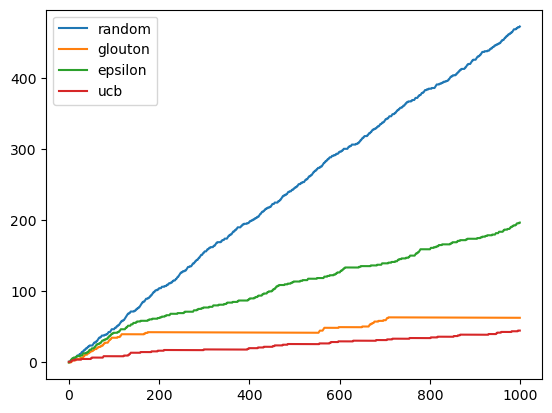

In [7]:
plt.plot(tme3.regret(bandit,jeu_random.rewards_t),label="random")
plt.plot(tme3.regret(bandit,jeu_glouton.rewards_t),label="glouton")
plt.plot(tme3.regret(bandit,jeu_epsilon.rewards_t),label="epsilon")
plt.plot(tme3.regret(bandit,jeu_ucb.rewards_t),label="ucb")
plt.legend()

In [8]:
#Après plusieurs tests en faisant varier N_ARMS, N_TIMES et K, on conclut que le random est le moins bon, suivi de epsilon.
#Ensuite, UCB et glouton sont quasiment aussi performant l'un que l'autre.